In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot



In [10]:
D0masMin = 1.75
D0masMax = 2.0
D0ptMin = 1.0

D0ExpCut = f"(D0mass > {D0masMin}) & (D0mass<{D0masMax}) & (D0_pT>{D0ptMin})"
nEventsSim=100000
centralityBins = [0,10,40,80]
features = [ "pt","z" , "lambda_1_1", "lambda_1_1half","lambda_1_2","lambda_1_3","eta"]

selected_iteration=0

tag = "ver0"
tag = "ver_test"

In [11]:
ptBinsEdges =( 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 15, 18, 30)
ptBinsEdges = np.array(ptBinsEdges)
valuesEff0 = [0.8040493, 0.83531431, 0.86378964, 0.8858829, 0.90171456, 0.91389318, 0.92173535, 0.92743685, 0.93525452, 0.94756974, 0.95040946, 0.96602388, 0.96862745] # 0-10%,
valuesEff1 = [0.83887934, 0.87066498, 0.89502397, 0.91200534, 0.92392761, 0.93324831, 0.94047693, 0.94662845, 0.94907014, 0.95762499, 0.96266307, 0.96608892, 0.96307934] # 10-40%
valuesEff2 = [0.91436481, 0.93592894, 0.94950428, 0.95879075, 0.96557282, 0.97033296, 0.97348525, 0.97777634, 0.97975429, 0.98211105, 0.98382422, 0.98780008, 0.99102773]  #40-80%
valuesEff = np.array([valuesEff0, valuesEff1, valuesEff2])


def getSimJetFinderEfficiency(pt, centralityBin): #centralityBin = 0 (0-10%) , 1(10-40%) or 2(40-80%)
    ptBin = np.digitize(pt, ptBinsEdges)-1
    if (ptBin<0):
        ptBin=0
    elif (ptBin>=len(valuesEff)):
        ptBin=len(valuesEff)-1
    return valuesEff[centralityBin][ptBin]

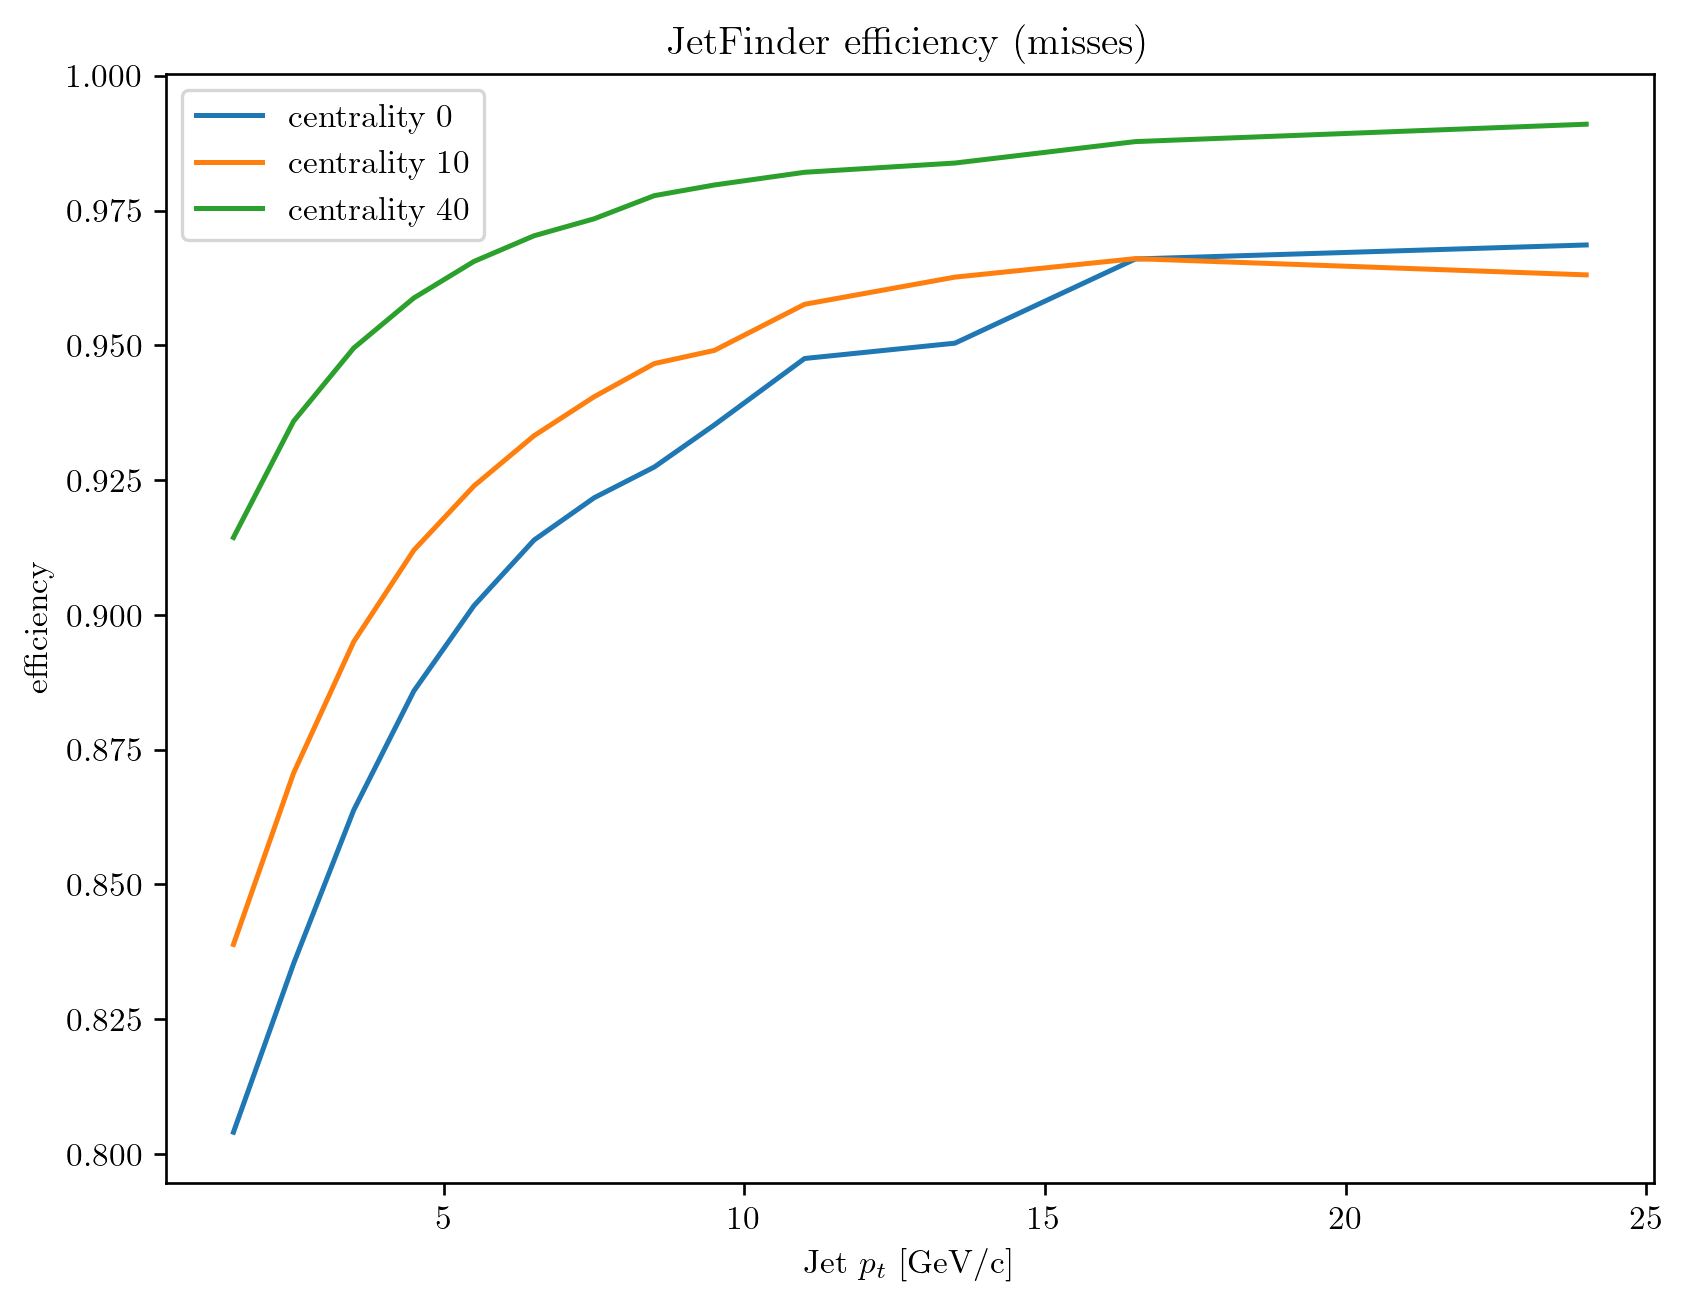

In [12]:
# plot efficiency

fig, ax = plt.subplots(figsize=(8, 6))
ptBinsEdges = np.array(ptBinsEdges)
ptMidBins = (ptBinsEdges[1:]+ptBinsEdges[:-1])/2
for i in range(len(centralityBins)-1):
    ax.plot(ptMidBins, valuesEff[i], label=f"centrality {centralityBins[i]}% - {centralityBins[i+1]}%")
ax.legend()
ax.set_xlabel(r"Jet $p_t$ [GeV/c]")
ax.set_ylabel("efficiency")
ax.set_title("JetFinder efficiency (misses)")
fig.savefig(f"realData/JetFinderEfficiency_{tag}.pdf")
plt.show()



In [13]:
nEvents = [0,0,0]

with uproot.open("/home/prozorov/dev/star/OUTPUT_2014_20012024.root") as file:
    hcentr = file["hcentrW"]
    centralityEvents=hcentr.values()
nEvents[0] = centralityEvents[7]+centralityEvents[8]
nEvents[1] = centralityEvents[4]+centralityEvents[5]+centralityEvents[6]
nEvents[2] = centralityEvents[0]+centralityEvents[1]+centralityEvents[2]+centralityEvents[3]
         
print(nEvents)
Ncoll = [952., 397., 58.]

[52042137.068949565, 156830917.4527531, 214807171.56601435]


In [14]:
wdata = []
sim_mc_recos = []
for i in range(len(centralityBins)-1):
    centralityCuts = f"(Centrality >= { centralityBins[i]}) & (Centrality < {centralityBins[i+1]})"
    print("Processing centrality bin: ", centralityCuts)

    embedding_tree = uproot.open("/home/prozorov/dev/star/output_jets.root:Jets")
    columns = ["McJetPt", "McJetD0Z", "McJetLambda_1_1", "McJetLambda_1_1half","McJetLambda_1_2","McJetLambda_1_3", "McJetEta"]
    sim_mc_reco= embedding_tree.arrays(columns, cut=centralityCuts + "& (RecoJetNConst!=0)", library="pd", entry_stop=nEventsSim)
    sim_mc_reco.rename(columns={"McJetPt": "pt", "McJetD0Z": "z",  "McJetLambda_1_1": "lambda_1_1", 
                                "McJetLambda_1_1half": "lambda_1_1half", "McJetLambda_1_2": "lambda_1_2", 
                                "McJetLambda_1_3": "lambda_1_3", "McJetEta" : "eta"}, inplace=True)

    sim_mc_reco["jetFinderEff"] = sim_mc_reco["pt"].apply( lambda x: getSimJetFinderEfficiency(x,i))
    saveFolder = f"realData/centrality{centralityBins[i]}_{centralityBins[i+1]}"
    saveFolder = saveFolder + f'/{tag}'
    weights_centrality= np.load(f"{saveFolder}/weights.npy")
    wdata.append( weights_centrality[selected_iteration,1,:]) #weights after last iteration for pull after step 1
    print (weights_centrality.shape)
    # wdata.append( np.ones(len(sim_mc_reco)) ) 
    sim_mc_recos.append(sim_mc_reco)

Processing centrality bin:  (Centrality >= 0) & (Centrality < 10)
(3, 2, 14853)
Processing centrality bin:  (Centrality >= 10) & (Centrality < 40)
(3, 2, 37314)
Processing centrality bin:  (Centrality >= 40) & (Centrality < 80)
(3, 2, 37321)


In [15]:
# a dictionary to hold information about the observables
obs = {}
nbins = 20

obs.setdefault('pt', {}).update({
    # 'bins':[1,3,5,7,10,13,20,30],
    'nbins': nbins,   'xlim': (1, 30),
    'xlabel': r'Jet $p_{t}$  [GeV/c]', 
    'symbol': r'$p_{t}$'
})

obs.setdefault('z', {}).update({
    'nbins': nbins,    'xlim': (0.15, 1.001), 
    'xlabel': r'Jet Momentum Fraction $z$', 
    'symbol': r'$z$'
})

obs.setdefault('lambda_1_1', {}).update({
    'nbins': nbins,    'xlim': (0, 0.65),    
    'xlabel': r'Jet Angularity $\lambda_{1}^{1}$', 
    'symbol': r'$\lambda_{1}^{1}$',
})

obs.setdefault('lambda_1_1half', {}).update({
    'nbins': nbins,    'xlim': (0, 0.35),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 
    'symbol': r'$\lambda_{1}^{1/2}$',
})

obs.setdefault('lambda_1_2', {}).update({
    'nbins': nbins,    'xlim': (0, 0.15),   
    'xlabel': r'Jet Angularity $\lambda_{1}^{2}$', 
    'symbol': r'$\lambda_{1}^{2}$',
})

obs.setdefault('lambda_1_3', {}).update({
    'nbins': nbins,    'xlim': (0, 0.06),   
    'xlabel': r'Jet Angularity $\lambda_{1}^{3}$', 
    'symbol': r'$\lambda_{1}^{3}$'
})

obs.setdefault('eta', {}).update({
    'nbins': nbins,    'xlim': (-0.6, 0.6),
    'xlabel': r'Jet  $\eta$', 
    'symbol': r'$\eta$'
})

# additional histogram and plot style information
hist_style = {'histtype': 'step', 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}

for obkey,ob in obs.items():
    if 'bins' not in ob:
        ob['bins'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins']+1)
    
    ob['bins'] = np.array(ob['bins'])
    # calculate midpoints of the bins 
    ob['midbins'] = 0.5*(ob['bins'][1:] + ob['bins'][:-1])
    # calculate widths of the bins
    ob['binwidth'] = ob['bins'][1:] - ob['bins'][:-1]
    

 # function to add a stamp to figures
def stamp(left_x, top_y,
          ax=None,
          delta_y=0.075,
          textops_update=None,
          **kwargs):
     # handle defualt axis
    if ax is None:
        ax = plt.gca()
    # text options
    textops = {'horizontalalignment': 'left',
               'verticalalignment': 'center',
               'fontsize': 8.5,
               'transform': ax.transAxes}
    if isinstance(textops_update, dict):
        textops.update(textops_update)
    # add text line by line
    for i in range(len(kwargs)):
        y = top_y - i*delta_y
        t = kwargs.get('line_' + str(i))
        if t is not None:
            ax.text(left_x, y, t, **textops)   

/tmp/ipykernel_334243/3314500529.py:42: RuntimeWarning: divide by zero encountered in divide
  Rcp = histCentralScaled/histPeripheralScaled
/tmp/ipykernel_334243/3314500529.py:42: RuntimeWarning: invalid value encountered in divide
  Rcp = histCentralScaled/histPeripheralScaled
/tmp/ipykernel_334243/3314500529.py:44: RuntimeWarning: divide by zero encountered in divide
  Rmp = histMidcentralScaled/histCentralScaled
/tmp/ipykernel_334243/3314500529.py:44: RuntimeWarning: invalid value encountered in divide
  Rmp = histMidcentralScaled/histCentralScaled
/tmp/ipykernel_334243/3314500529.py:46: RuntimeWarning: invalid value encountered in divide
  Rcm = histCentralScaled/histMidcentralScaled
/tmp/ipykernel_334243/3314500529.py:54: RuntimeWarning: divide by zero encountered in divide
  ax0.errorbar(ob['midbins'], Rcp, xerr=0.5*ob['binwidth'], yerr= np.sqrt(histCentral)/histPeripheral, fmt='o', color='black', label=labels[0])
/tmp/ipykernel_334243/3314500529.py:54: RuntimeWarning: invalid va

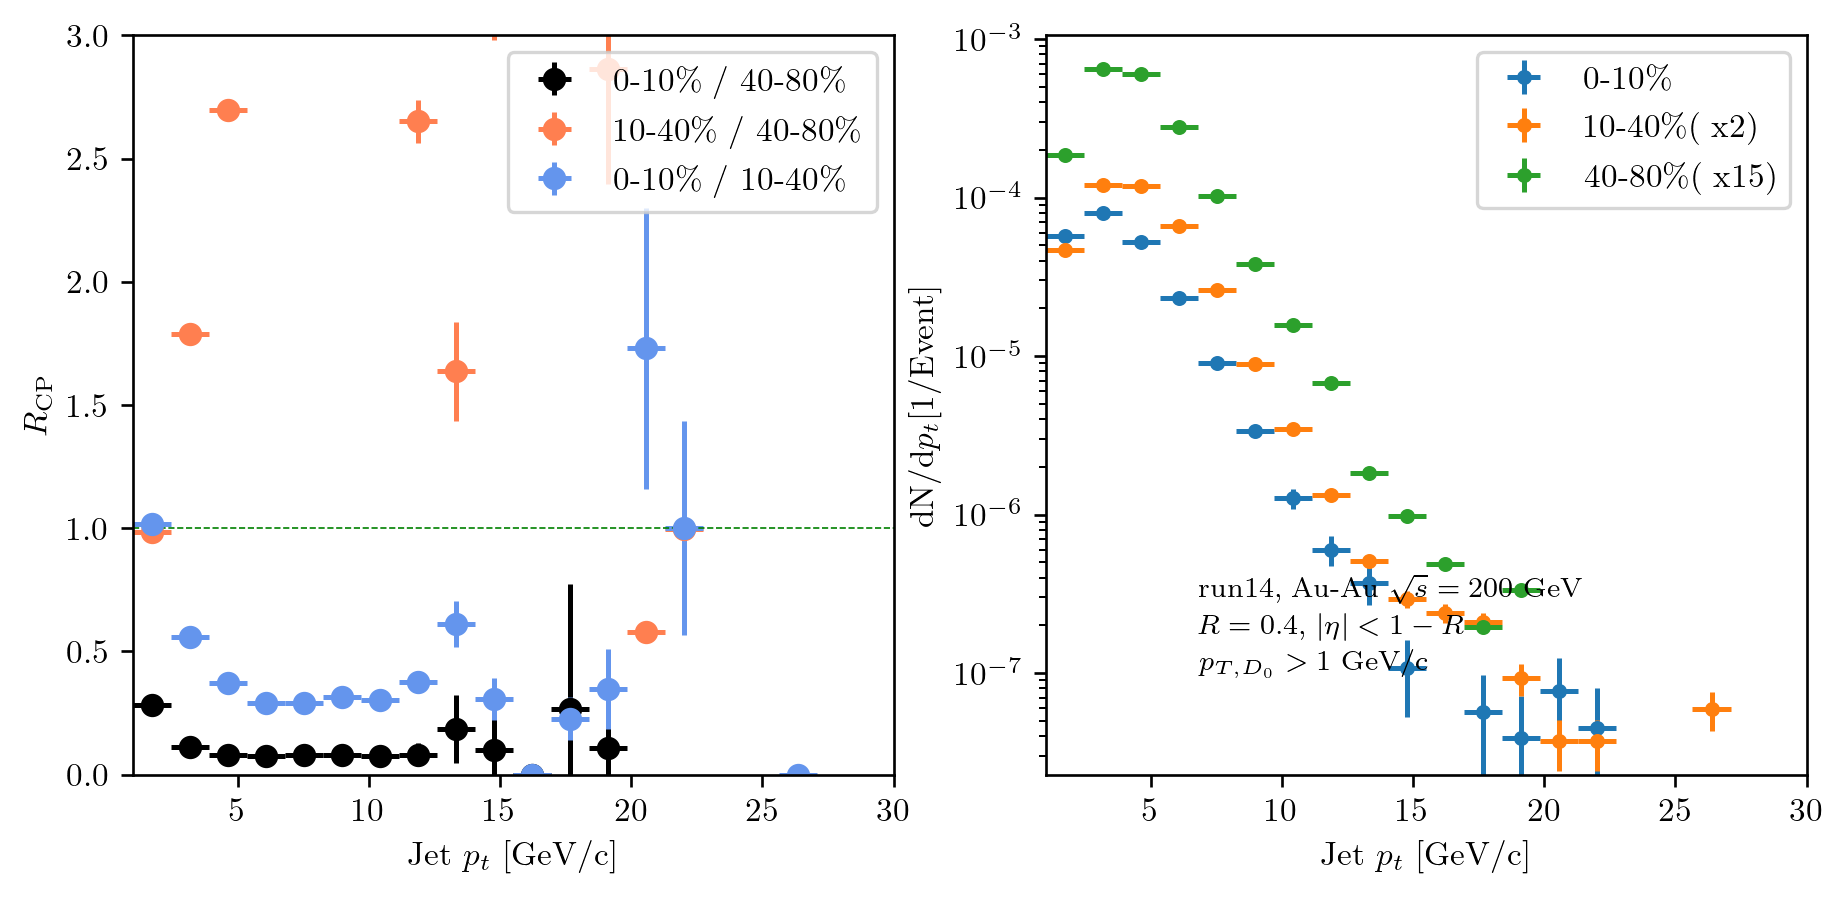

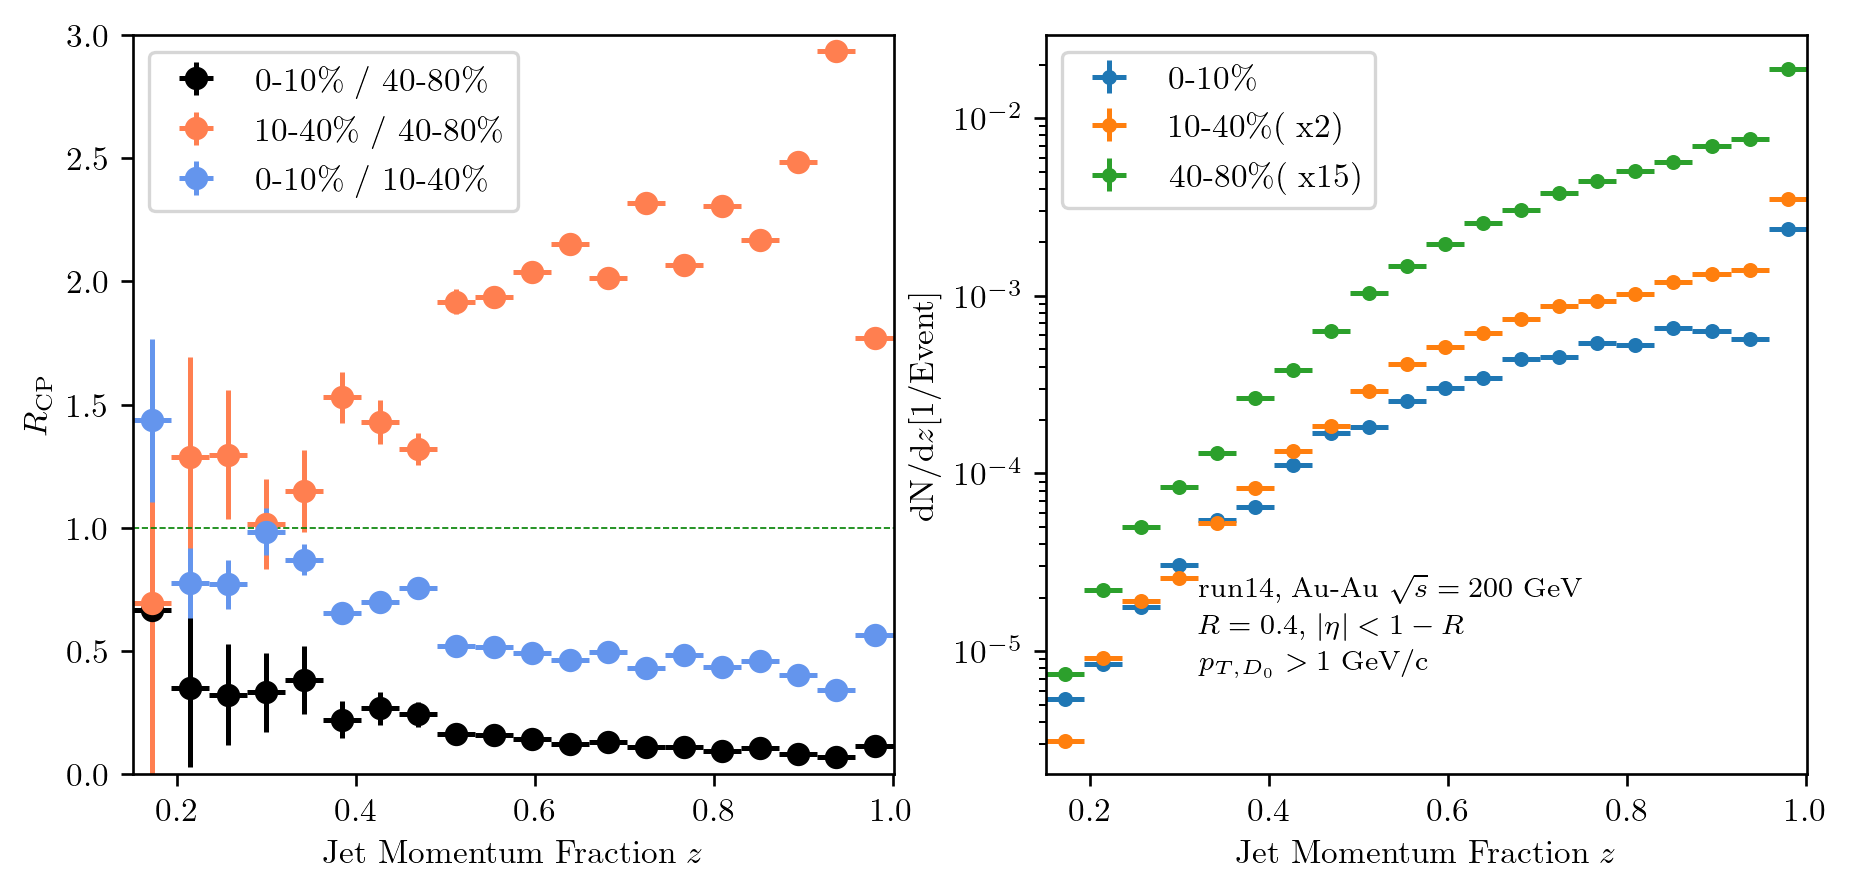

/tmp/ipykernel_334243/3314500529.py:46: RuntimeWarning: divide by zero encountered in divide
  Rcm = histCentralScaled/histMidcentralScaled
/tmp/ipykernel_334243/3314500529.py:56: RuntimeWarning: divide by zero encountered in divide
  ax0.errorbar(ob['midbins'], Rcm, xerr=0.5*ob['binwidth'], yerr= np.sqrt(histCentral)/histMidcentral, fmt='o', color='cornflowerblue', label=labels[2])


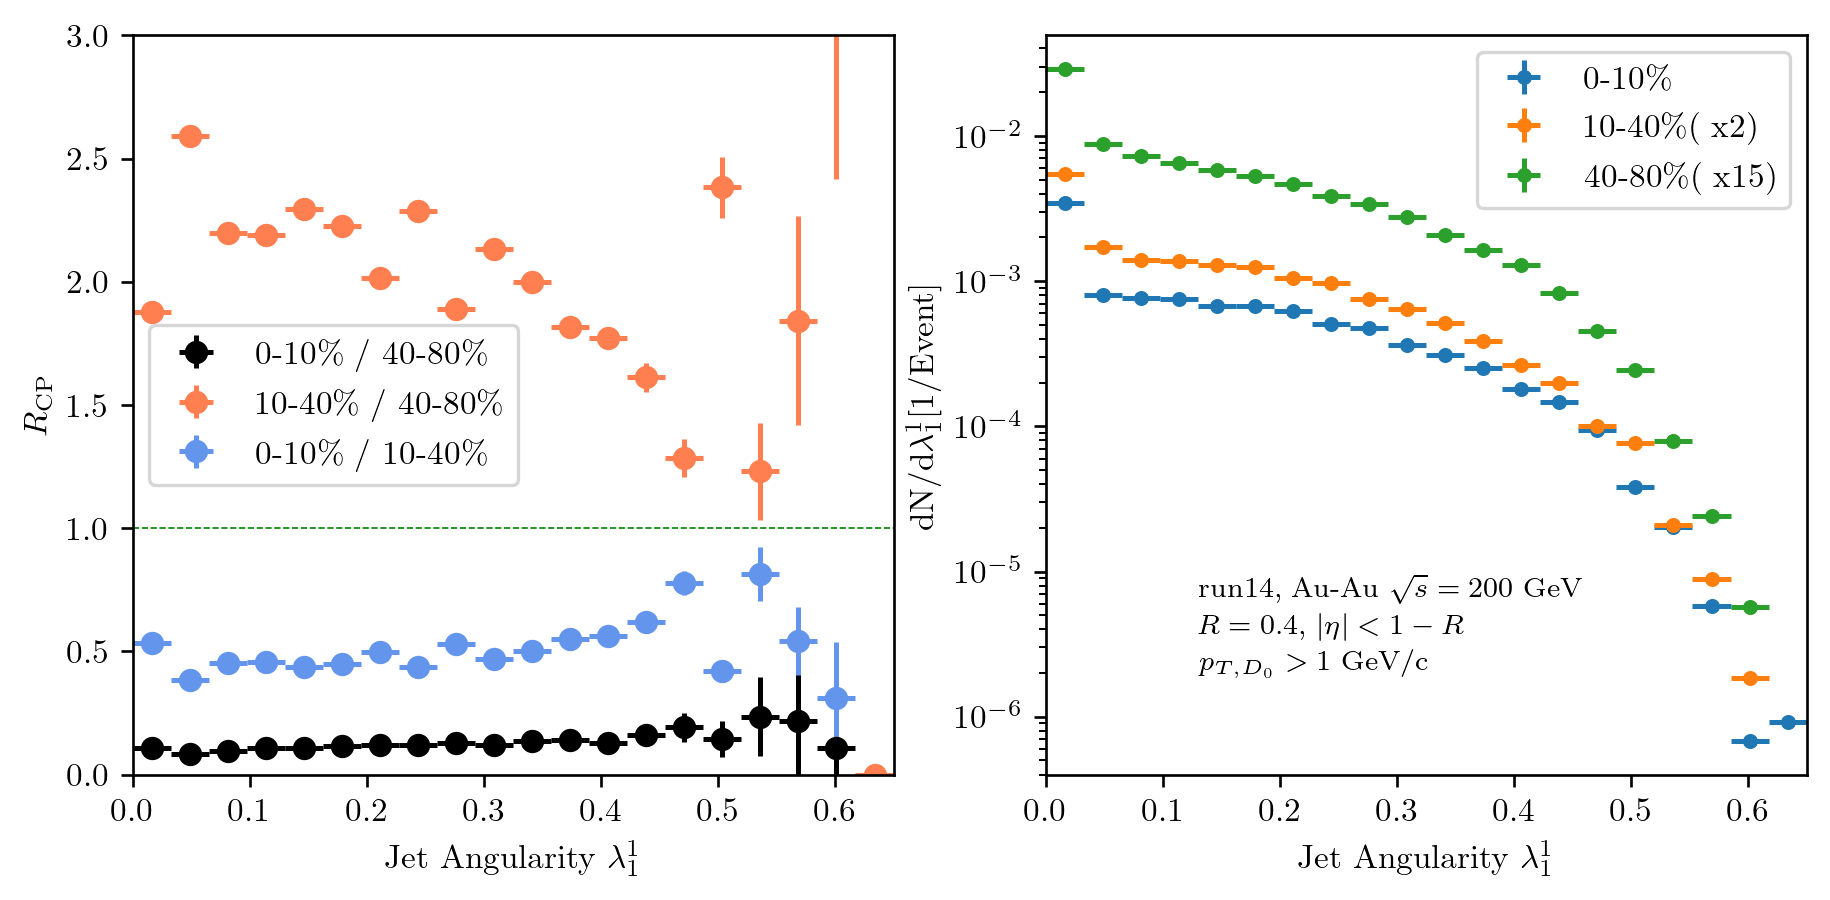

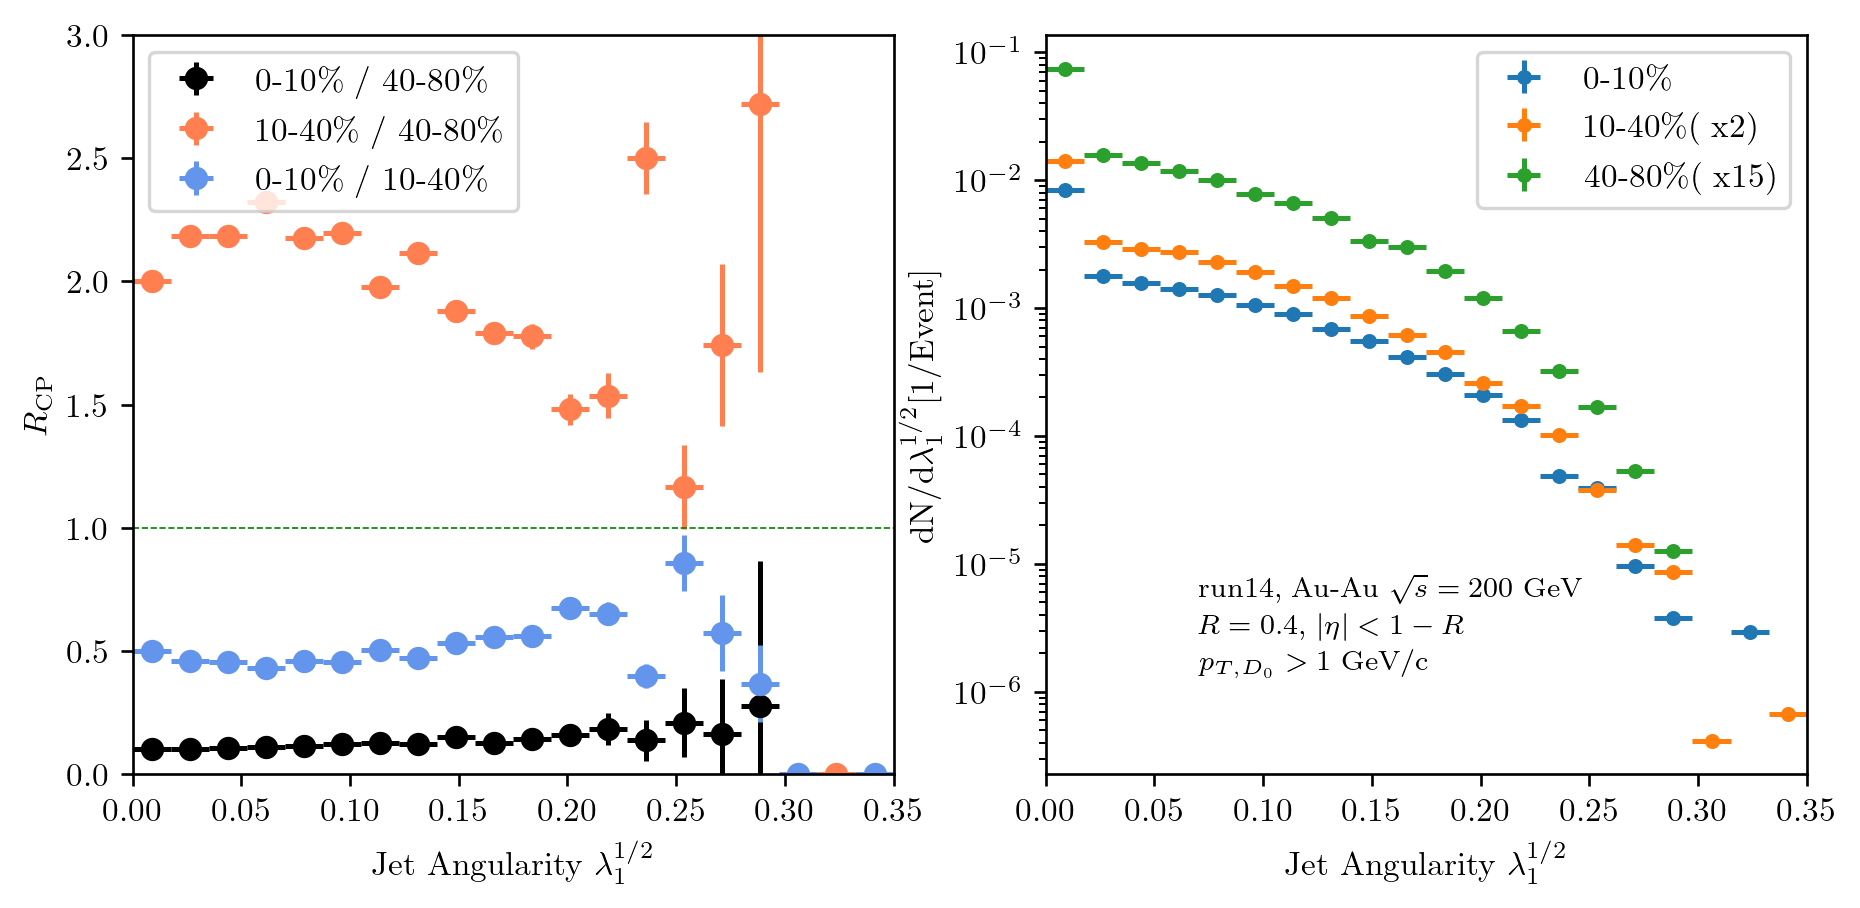

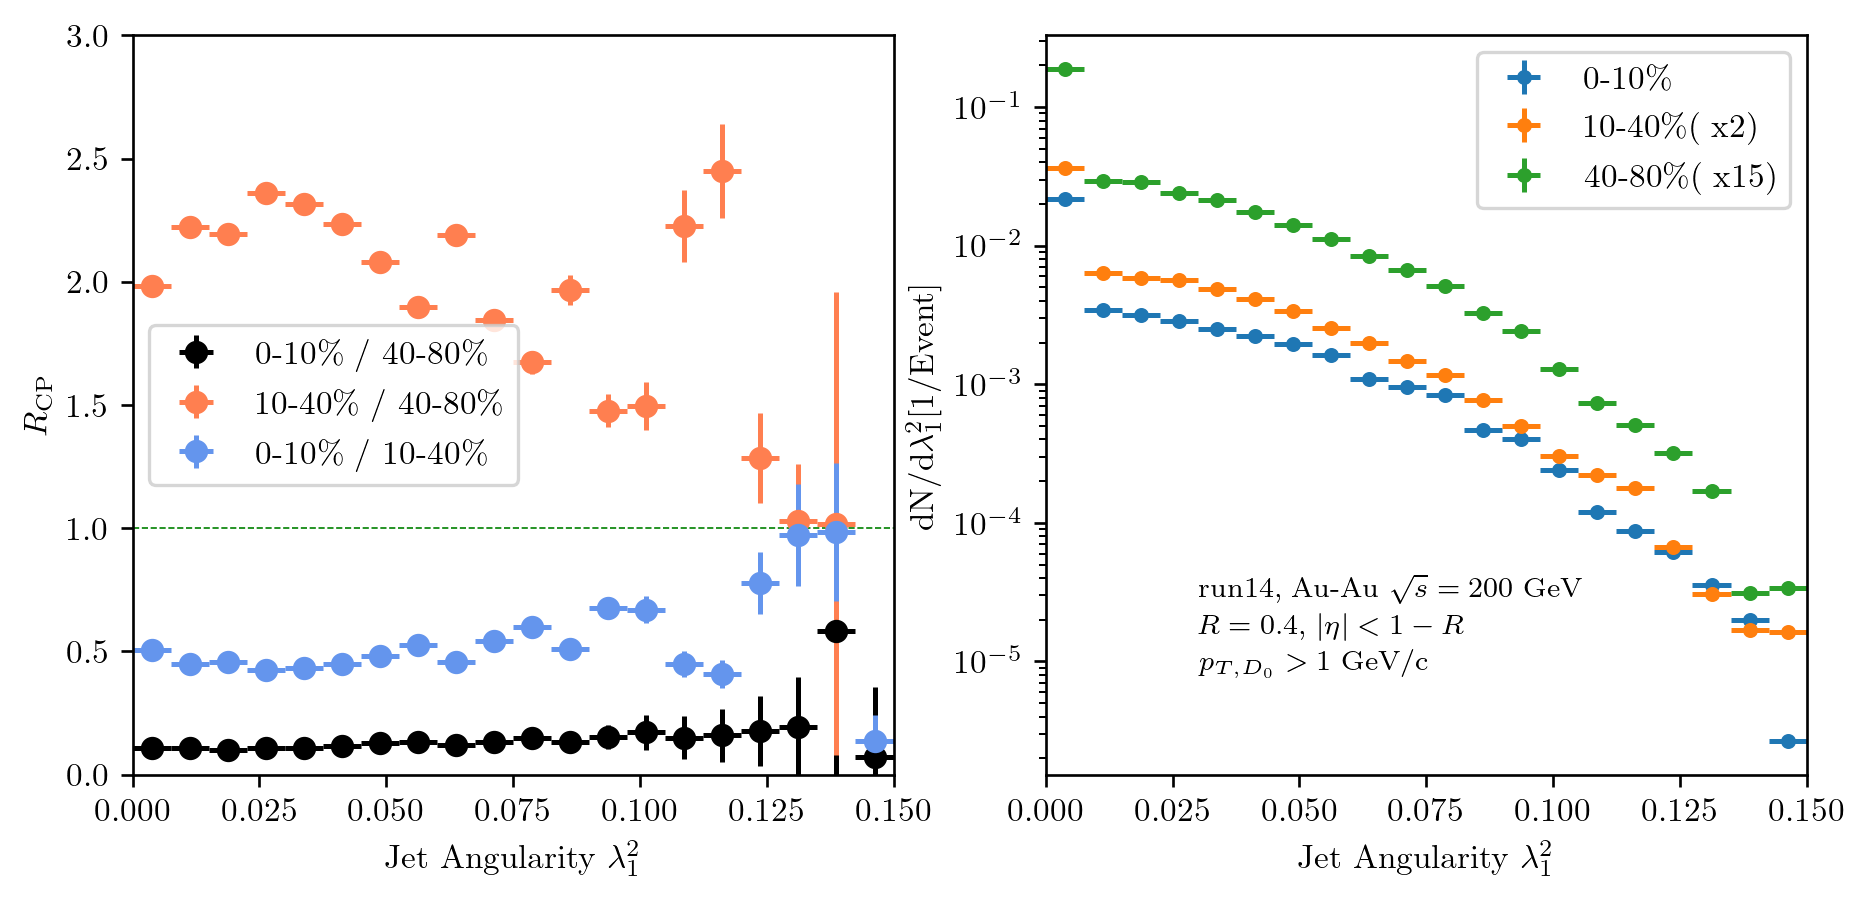

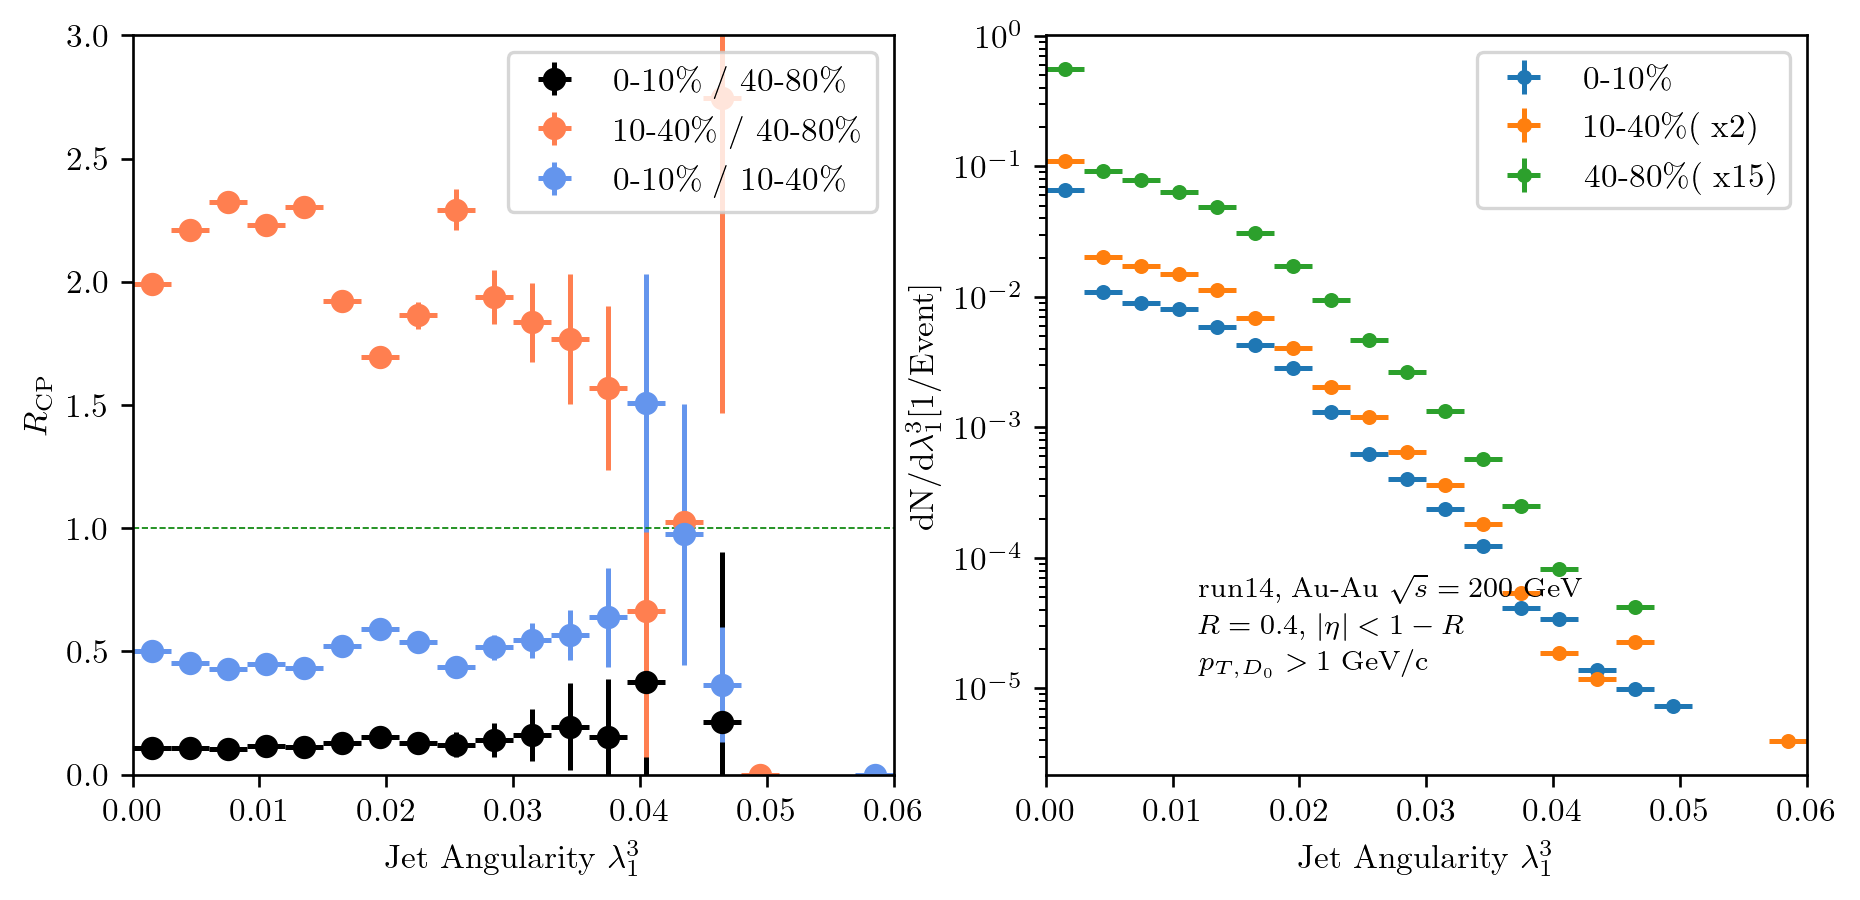

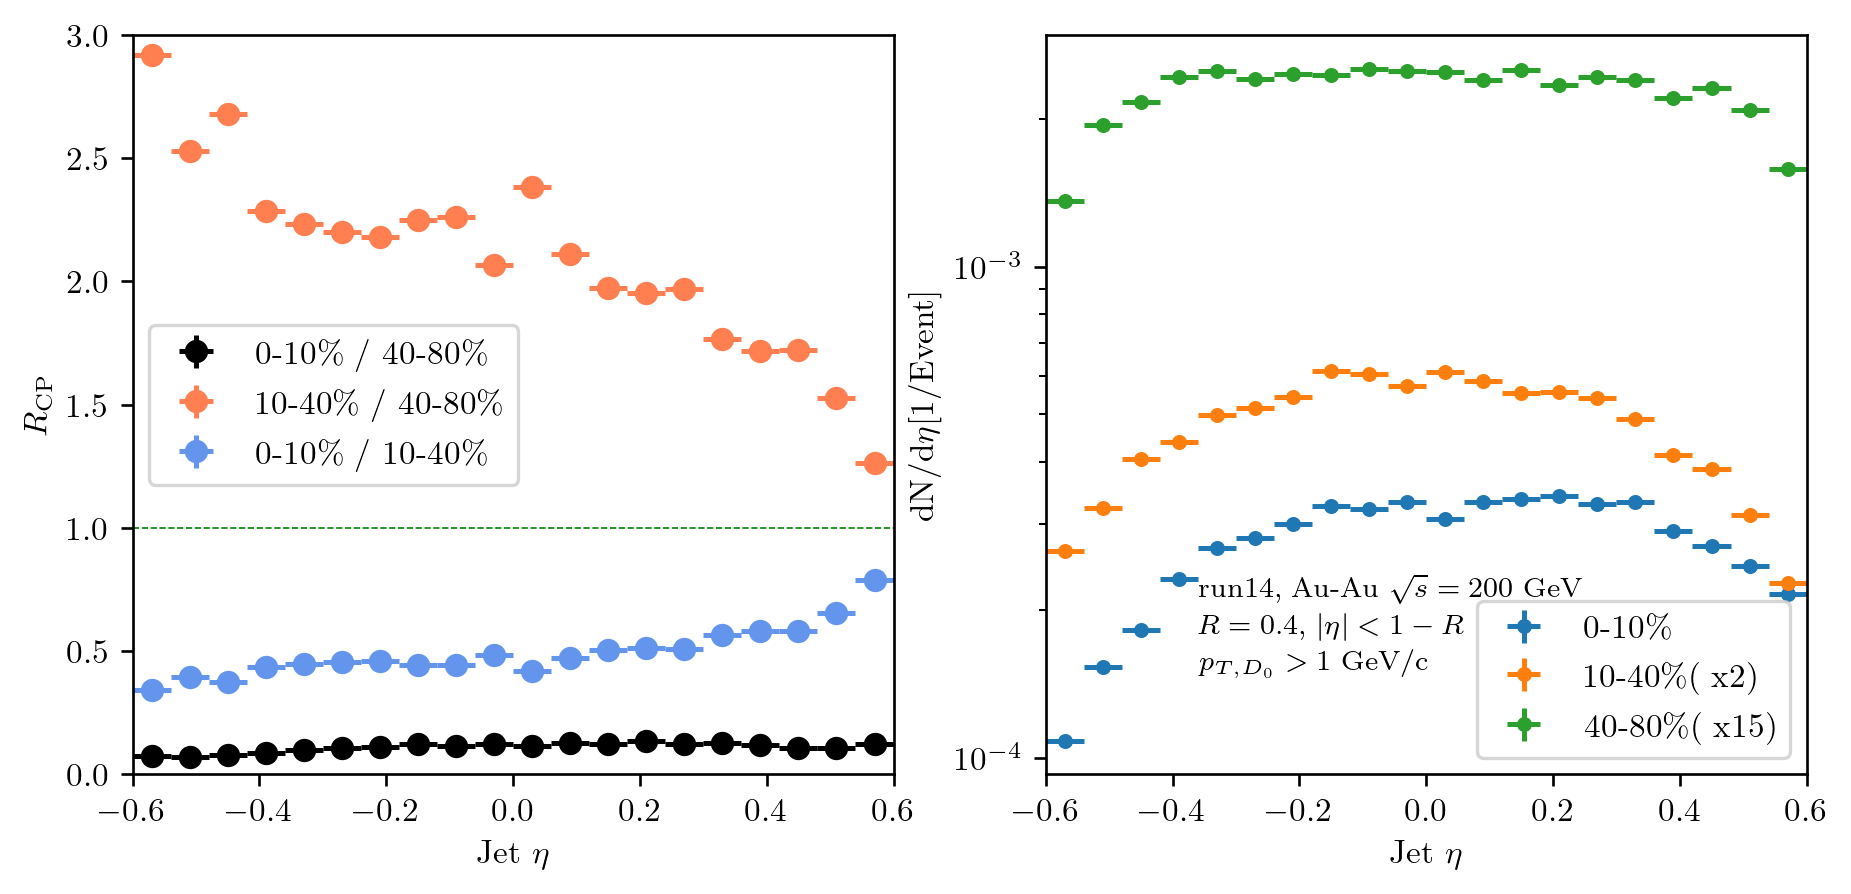

In [17]:
#calculate Rcp for all observables
plt.rcParams['figure.figsize'] = (9,4)
plt.rcParams['figure.dpi'] = 240
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})

for i,(obkey,ob) in enumerate(obs.items()):
    fig, (ax0, ax1) = plt.subplots(1,2)
    ax0.set_xlim(ob['xlim'])
    ax0.set_ylim(0, 3)
    if obkey == "pt":
        ax0.set_ylim(0, 3)
    
    central = sim_mc_recos[0]
    midcentral = sim_mc_recos[1]
    peripheral = sim_mc_recos[2]
   
    central_multifold_weights = wdata[0]
    midcentral_multifold_weights = wdata[1]
    peripheral_multifold_weights = wdata[2]


    # plot the central data
    histCentral, _ = np.histogram(central[obkey], bins=ob['bins'], weights= central_multifold_weights / central["jetFinderEff"])
    histMidcentral , _ = np.histogram(midcentral[obkey], bins=ob['bins'], weights=midcentral_multifold_weights/ midcentral["jetFinderEff"])
    histPeripheral, _ = np.histogram(peripheral[obkey], bins=ob['bins'], weights=peripheral_multifold_weights/ peripheral["jetFinderEff"])


    histCentralScaled = histCentral/nEvents[0]
    histMidcentralScaled = histMidcentral/nEvents[1]
    histPeripheralScaled = histPeripheral/nEvents[2]

    histCentralScaled /= Ncoll[0]
    histMidcentralScaled /= Ncoll[1]
    histPeripheralScaled /= Ncoll[2]


    # divide central by peripheral  
    Rcp = histCentralScaled/histPeripheralScaled
  # ///////////////////////////////////////
    Rmp = histMidcentralScaled/histCentralScaled
    # ///////////////////////////////////////
    Rcm = histCentralScaled/histMidcentralScaled
  

    labels = [f' {centralityBins[0]}-{centralityBins[1]}\%  / {centralityBins[2]}-{centralityBins[3]}\%',
               f'{centralityBins[1]}-{centralityBins[2]}\% / {centralityBins[2]}-{centralityBins[3]}\%',
               f' {centralityBins[0]}-{centralityBins[1]}\%  / {centralityBins[1]}-{centralityBins[2]}\%']
    
    # plot the Rcp
    ax0.errorbar(ob['midbins'], Rcp, xerr=0.5*ob['binwidth'], yerr= np.sqrt(histCentral)/histPeripheral, fmt='o', color='black', label=labels[0])
    ax0.errorbar(ob['midbins'], Rmp, xerr=0.5*ob['binwidth'], yerr= np.sqrt(histMidcentral)/histPeripheral, fmt='o', color='coral', label=labels[1])
    ax0.errorbar(ob['midbins'], Rcm, xerr=0.5*ob['binwidth'], yerr= np.sqrt(histCentral)/histMidcentral, fmt='o', color='cornflowerblue', label=labels[2])
    ax0.set_xlabel(ob['xlabel'])
    ax0.set_ylabel( r'$R_{\rm CP}$')
    ax0.legend()
    # plot constant line at 1
    ax0.axhline(1, color='green',ls='--',  lw=0.5)

    # plot the data distributions

    ax1.set_xlim(ob['xlim'])
    ax1.set_yscale('log')
    labels = [f' {centralityBins[0]}-{centralityBins[1]}\%', f'{centralityBins[1]}-{centralityBins[2]}\%', f' {centralityBins[2]}-{centralityBins[3]}\%']

  

    #  histCentralScaled = histCentral/nEvents[0]
    # histMidcentralScaled = histMidcentral/nEvents[1]
    # histPeripheralScaled = histPeripheral/nEvents[2]
        
    ax1.errorbar(ob['midbins'], histCentral/ob['binwidth']/nEvents[0], xerr=0.5*ob['binwidth'], yerr=np.sqrt(histCentral)/nEvents[0], fmt='.', label=labels[0], markersize=7)
    ax1.errorbar(ob['midbins'], 2*histMidcentral/ob['binwidth']/nEvents[1], xerr=0.5*ob['binwidth'], yerr=np.sqrt(histMidcentral)/nEvents[1], fmt='.', label=labels[1]+'( x2)',markersize=7)
    ax1.errorbar(ob['midbins'], 15*histPeripheral/ob['binwidth']/nEvents[2], xerr=0.5*ob['binwidth'], yerr=np.sqrt(histPeripheral)/nEvents[2], fmt='.',  label=labels[2]+'( x15)',markersize=7)

    ax1.set_xlabel(ob['xlabel'])
    ax1.set_ylabel('dN/d'+ob['symbol'] + '[1/Event]')
    ax1.legend()

        # stamp to put on the plots
    stamp( left_x=0.2, top_y=0.25, delta_y=0.05, ax=ax1,
                 line_0=r'run14, Au-Au $\sqrt{s}=200$ GeV',
                 line_1=r'$R=0.4$, $|\eta|<1-R$',
                 line_2=r'$p_{T,D_0}>1$ GeV/c')
    plt.show()

    fig.savefig(f"realData/rcp/{obkey}_Rcp.pdf")
    
   